In [1]:
!nvidia-smi

Fri Jul  5 16:42:54 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P8     5W /  N/A |    198MiB /  6078MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
from pathlib import Path
from glob import glob

import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets as ds, models, transforms as tf, utils

import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Data

Create a `VisionDataset` subclass for the Spacenet Vegas dataset.

The dataset has 17334 image-label pairs, where the image is a 300x300 multispectral image consisting of the following 8-bands (in this order):
- Coastal
- Blue
- Green
- Yellow
- Red
- Red-Edge
- Near-IR1
- Near-IR2

The labels are 300x300 arrays containing the class of each pixels. There are only 2 classes: 
- 1 == 'building'
- 2 == 'no building'

For this exercise, we will convert the labels to a single value (0 or 1), representing wether the image contains a building or not.

In [4]:
class SpacenetVegas(ds.VisionDataset):
    def __init__(self, path='data', x_folder='train-img', y_folder='train-labels', exts=['npy'], load_fn=np.load, x_tf=None, y_tf=None, cache=None):
        super(SpacenetVegas).__init__()
        self.x_path = f'{path}/{x_folder}'
        self.y_path = f'{path}/{y_folder}'
        self._load_filenames(path, x_folder, y_folder, exts)
        
        self.x_tf = x_tf or (lambda x: x)
        self.y_tf = y_tf or (lambda x: x)
        self.x_tf2 = RandomFlip()

        if cache is None:
            self.cache = {}
            for i in range(len(self.fnames)):
                self.cache[i] = self._load_xy_from_file(i)
                if (i + 1) % 1000 == 0:
                    print(f'Cached {len(self.cache)}  x, y pairs')
        else:
            self.cache = cache

        self.is_small_class = torch.ByteTensor([v[1] for v in self.cache.values()])

        print(f'Found {len(self.fnames)} x, y pairs')
        print(f'Cached {len(self.cache)}  x, y pairs')
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, i):
        if isinstance(i, (int, np.integer)):
            return self._load_xy(i)
        if isinstance(i, np.ndarray) or isinstance(i, torch.Tensor):
            i = i.squeeze()
            assert i.ndim in (0, 1), "too many dimensions"
            if i.ndim == 0:
                return self._load_xy(i)
            return [self._load_xy(j) for j in i]
        if isinstance(i, slice):
            return [self._load_xy(j) for j in range(*i.indices(len(self.fnames)))]
        assert False, f"__getitem__(i): Invalid index"

    def _load_x(self, i):
        return self.cache[i][0]

    def _load_xy(self, i):
        x, y = self.cache[i]
        return self.x_tf2(x), y

    def _load_xy_from_file(self, i):
        x = np.load(f'{self.x_path}/{self.fnames[i]}').astype(float) / 255
        y = np.load(f'{self.y_path}/{self.fnames[i]}')
        
        return self.x_tf(x), self.y_tf(y)

    def _load_filenames(self, path, x_folder, y_folder, exts):
        query_expr = f"*[{'|'.join('.' + ext for ext in exts)}]"
        print(f'{self.x_path}/{query_expr}/')
        x_fnames = [Path(f).name for f in glob(f'{self.x_path}/{query_expr}')]
        y_fnames = [Path(f).name for f in glob(f'{self.y_path}/{query_expr}')]
        self._verify_xy_pairs(x_fnames, y_fnames)
        
        self.fnames = x_fnames

    def _verify_xy_pairs(self, x_fnames, y_fnames):
         assert set(x_fnames) == set(y_fnames)

## Transforms

In [5]:
class Downsample(object):
    def __init__(self, factor):
        self.factor = factor
    
    def __call__(self, arr):
        return np.ascontiguousarray(arr[::self.factor, ::self.factor])
    
    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'


class RandomFlip(object):
    def __init__(self, h_prob=0.5, v_prob=0.5):
        self.h_prob = h_prob
        self.v_prob = v_prob
    
    def __call__(self, arr):
        if torch.rand(1) < self.v_prob:
            arr = arr.flip(1)
        if torch.rand(1) < self.h_prob:
            arr = arr.flip(2)
        return arr

    def __repr__(self):
        return self.__class__.__name__ + f'(h_prob={self.h_prob}, v_prob={self.v_prob})'


class ChannelSelect(object):
    def __init__(self, channels):
        self.channels = channels
    
    def __call__(self, arr):
        return np.ascontiguousarray(arr[..., self.channels])

    def __repr__(self):
        return self.__class__.__name__ + f'(channels={self.channels})'
    


For this experiment, we are training on RGB, so we select channels 4, 2, and 1.

For computational cost reasons, we downsample the inputs by a factor of 8 to get images of size 38x38.

For training, we augment the data using random horizontal and vertical flips.

In [8]:
train_transform = tf.Compose([
    ChannelSelect([4, 2, 1]),
    Downsample(8),
    RandomFlip(),
    tf.Lambda(lambda x: (torch.Tensor(x).permute(2, 0, 1)))
])

val_transform = tf.Compose([
    ChannelSelect([4, 2, 1]),
    Downsample(8),
    tf.Lambda(lambda x: torch.Tensor(x).permute(2, 0, 1))
])

y_transform = tf.Compose([
    Downsample(8),
    tf.Lambda(lambda x: (torch.Tensor(x) == 1).any().long())
])


In [6]:
import pickle

# with open('train_ds.pkl', 'wb') as f:
#     pickle.dump(train_ds.cache, f)

with open('train_ds_421.pkl', 'rb') as f:
    cache = pickle.load(f)

In [9]:
import copy

train_ds = SpacenetVegas(x_tf=train_transform, y_tf=y_transform, cache=cache)
val_ds   = copy.deepcopy(train_ds)

assert len(train_ds) == len(val_ds)

data/train-img/*[.npy]/
Found 17334 x, y pairs
Cached 17334  x, y pairs


Check data

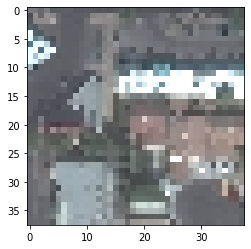

In [9]:
train_ds.x_tf2 = RandomFlip()
val_ds.x_tf2 = lambda x: x
plt.imshow(train_ds[0][0].permute(1, 2, 0))

In [216]:
len(train_ds.cache), len(val_ds.cache)

(17334, 17334)

# Split into train and validation sets using `SubsetRandomSampler()`

In [10]:
train_split_size = int(len(train_ds) * .85 // 1)
val_split_size = len(train_ds) - train_split_size
train_split_size, val_split_size

inds = np.arange(len(train_ds))
np.random.shuffle(inds)

In [11]:
train_sampler = data.SubsetRandomSampler(inds[:train_split_size])
val_sampler = data.SubsetRandomSampler(inds[train_split_size:])

# Model

In [12]:
class ClfModel(nn.Module):

    def __init__(self, params):
        super().__init__()

        self.net = params['base_model']
        self.net.fc = nn.Linear(self.net.fc.in_features, params['nclasses'])

    def forward(self, X):
        out = self.net(X)
        return out


In [13]:
model_params = {}
model_params['base_model'] = models.resnet18(pretrained=False).cuda()
model_params['nclasses'] = 2


In [14]:
model_RGB = ClfModel(model_params).cuda()
model_RGB.net._modules['conv1'] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False).cuda()
model_RGB.net._modules['maxpool'] = nn.Identity().cuda()

# Training

In [15]:
def save_model(model, name, info={}):
    state = {
        'model': model.state_dict(),
        'info': info
    }
    path = F"models/{name}" 
    torch.save(state, path)

In [123]:
import time

    
def validate(model, criterion, val_dl):
    
    val_loss = 0.
    val_corrects = 0
    model.eval()
    
    with torch.no_grad():
        for i, (batch, labels) in enumerate(val_dl):
            N = batch.shape[0]
            batch = batch.cuda()

            preds = model(batch).detach().cpu()
            val_loss += criterion(preds, labels)
            val_corrects += (preds.argmax(dim=-1) == labels).detach().cpu().float().sum()

    val_acc = val_corrects.float() / len(val_dl.sampler)
    val_loss /= len(val_dl.sampler)
    return val_loss, val_acc


def train_epoch(model, train_dl, criterion, optimizer):
    
    epoch_loss = 0.
    train_corrects = 0

    model.train()
    for i, (batch, labels) in enumerate(train_dl):
        N = batch.shape[0]
        batch = batch.cuda()
        labels = labels.cuda()

        preds = model(batch)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.detach().cpu()
        train_corrects += (preds.argmax(dim=-1) == labels).detach().cpu().float().sum()

    train_acc = train_corrects.float() / len(train_dl.sampler)
    epoch_loss /= len(train_dl.sampler)
    return epoch_loss, train_acc


def train_clf(model, train_dl, val_dl, optimizer, sched, params, criterion=nn.CrossEntropyLoss(), callback=lambda x: None, save_name='model', best_acc=0.85):
    '''Train a classification model.
    
    Args:
        - model: The model to be trained (must be a `nn.Module`).
        - train_dl: A `torch.utils.data.Dataloader` for training data.
        - val_dl: A `torch.utils.data.Dataloader` for validation data.
        - optimizer: The optimizer to use for training.
        - sched: The LR scheduler to use for training. `sched.step()` will be called after each epoch.
        - params: Additional training parameters.
        - criterion: Loss function.
        - callback: A callback that is called at the end of each epoch.
        - save_name: Filename to use for saving the model.
        - best_acc: Initial value for best-accuracy-so-far.
    '''

    log = [None] * params['epochs']
    
    torch.cuda.empty_cache()
    for epoch in range(params['epochs']):
        
        start_time = time.time()

        # train (fwd pass and backprop)
        epoch_loss, train_acc = train_epoch(model, train_dl, criterion, optimizer)

        # validate
        val_loss, val_acc = validate(model, criterion, val_dl)

        # save best model so far
        # save only if there is an improvement of >=0.05%
        if val_acc >= (best_acc + 0.005):
            best_acc = val_acc
            info = {'acc': val_acc, 'epoch': epoch, 'val_loss': val_loss, 'lr': optimizer.param_groups[0]['lr']}
            save_model(model, save_name, info=info)

        lr = optimizer.param_groups[0]['lr']
        print('epoch: %3d, lr: %0.8f, epoch_loss: %4.4f, val_loss: %4.4f, train_acc: %0.4f, val_acc: %0.4f, best: %0.4f, time: %0.1f' % \
              (epoch,      lr,        epoch_loss,        val_loss,        train_acc,        val_acc,        best_acc,    time.time() - start_time))
        sched.step()
        callback(model)
        
        log[epoch] = (lr, epoch_loss, val_loss, train_acc, val_acc)

    return np.array(log)


In [30]:
train_params = {}
train_params['batch_size'] = 64
train_params['val_batch_size'] = 512

In [31]:
train_dl = data.DataLoader(train_ds, sampler=train_sampler, batch_size=train_params['batch_size'], pin_memory=False, num_workers=4)
val_dl = data.DataLoader(val_ds, sampler=val_sampler, batch_size=train_params['val_batch_size'], pin_memory=False, num_workers=4)

In [120]:

train_params['epochs'] = 10
train_params['learning_rate'] = 1e-1
train_params['model_save_name'] = 'resnet18_421'

optimizer = optim.SGD(model_RGB.parameters(), lr=train_params['learning_rate'], momentum=0.9, weight_decay=5e-4)

sched = optim.lr_scheduler.CosineAnnealingLR(optimizer, train_params['epochs'], eta_min=train_params['learning_rate'] / 10)

log = train_clf(model_RGB, train_dl, val_dl, optimizer, sched, train_params, save_name=train_params['model_save_name'])


epoch:   0, lr: 0.10000000, epoch_loss: 25.3539, val_loss: 1.0260, train_acc: 0.9557, val_acc: 0.9350, best: 0.9350, time: 34.9
epoch:   1, lr: 0.09779754, epoch_loss: 24.5652, val_loss: 1.7354, train_acc: 0.9599, val_acc: 0.9212, best: 0.9350, time: 35.2
epoch:   2, lr: 0.09140576, epoch_loss: 24.4908, val_loss: 0.7031, train_acc: 0.9577, val_acc: 0.9546, best: 0.9546, time: 35.1
epoch:   3, lr: 0.08145034, epoch_loss: 23.0466, val_loss: 3.2039, train_acc: 0.9610, val_acc: 0.6405, best: 0.9546, time: 35.1
epoch:   4, lr: 0.06890576, epoch_loss: 21.5317, val_loss: 1.1174, train_acc: 0.9627, val_acc: 0.9477, best: 0.9546, time: 35.1
epoch:   5, lr: 0.05500000, epoch_loss: 20.1256, val_loss: 1.4209, train_acc: 0.9667, val_acc: 0.9489, best: 0.9546, time: 35.2
epoch:   6, lr: 0.04109424, epoch_loss: 18.7702, val_loss: 0.7268, train_acc: 0.9690, val_acc: 0.9458, best: 0.9546, time: 35.2
epoch:   7, lr: 0.02854966, epoch_loss: 17.2116, val_loss: 0.6261, train_acc: 0.9699, val_acc: 0.9592, b

In [61]:
from datetime import datetime
np.save(f'logs/{train_params["model_save_name"]}--[{datetime.now()}]', log)

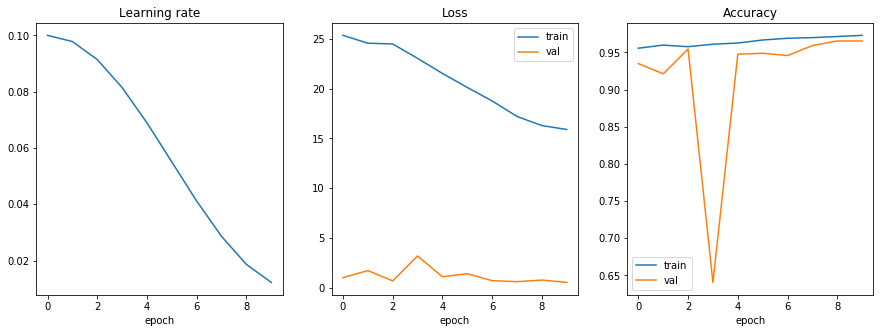

In [122]:
epochs = np.arange(len(log))
lr = log[:, 0]
train_loss, val_loss = log[:, 1], log[:, 2]
train_acc, val_acc = log[:, 3], log[:, 4]

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(epochs, lr)
plt.title('Learning rate')
plt.xlabel('epoch')

plt.subplot(132)
plt.plot(epochs, train_loss, epochs, val_loss)
plt.legend(('train', 'val'))
plt.title('Loss')
plt.xlabel('epoch')

plt.subplot(133)
plt.plot(epochs, train_acc, epochs, val_acc)
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend(('train', 'val'))

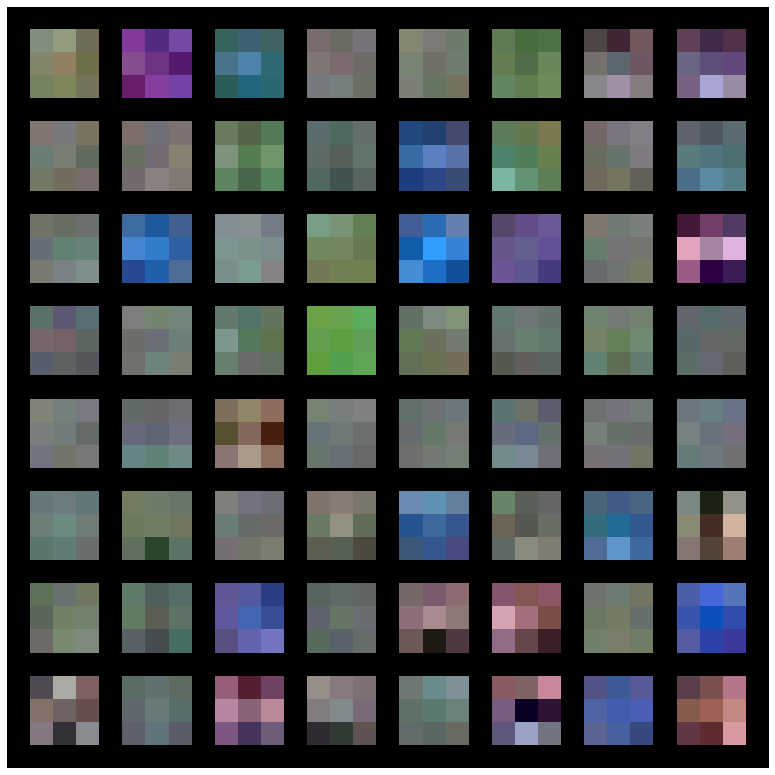

In [124]:
fs = model_RGB.net._modules['conv1'].weight.data.clone().detach().cpu()
grid = utils.make_grid(fs, normalize=True, scale_each=False, padding=1).permute(1, 2, 0)

plt.figure(figsize=(14,14))
plt.imshow(grid, cmap='gray')
plt.axis('off')
plt.show()

In [159]:
nn.Sequential(*list(model.net._modules.values())[:])


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Identity()
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

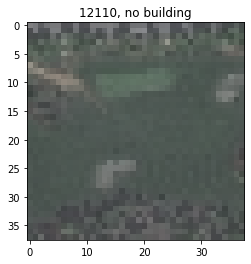

tensor([[0.9534, 0.0466]], device='cuda:0')

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
torch.Size([64, 1, 38, 38])


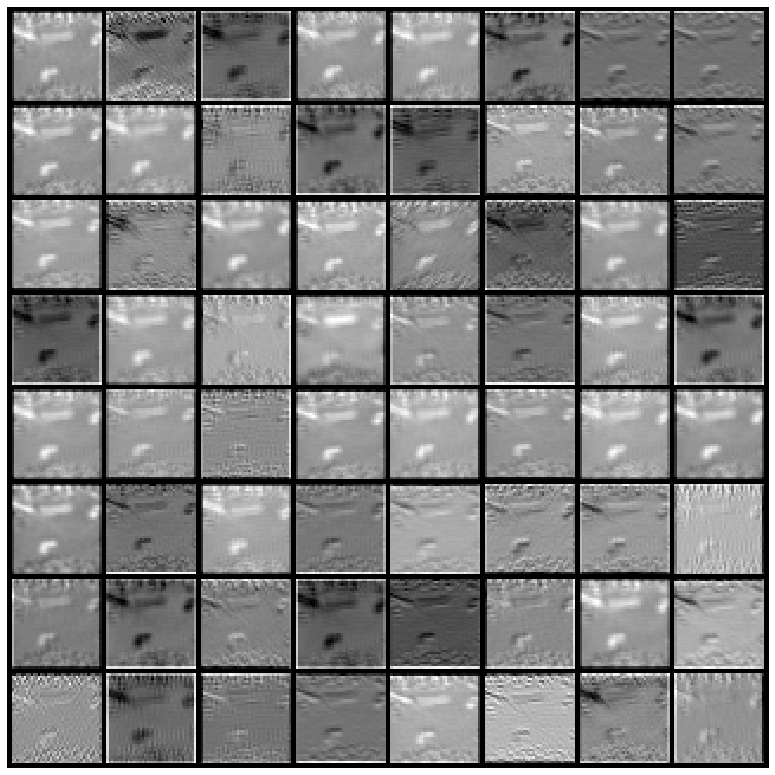

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([64, 1, 38, 38])


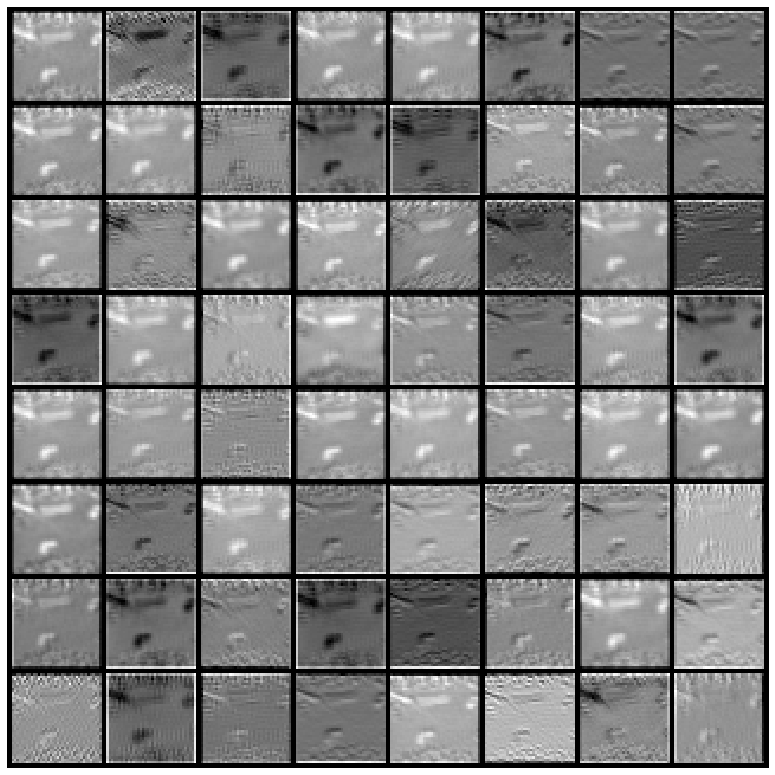

Identity()
torch.Size([64, 1, 38, 38])


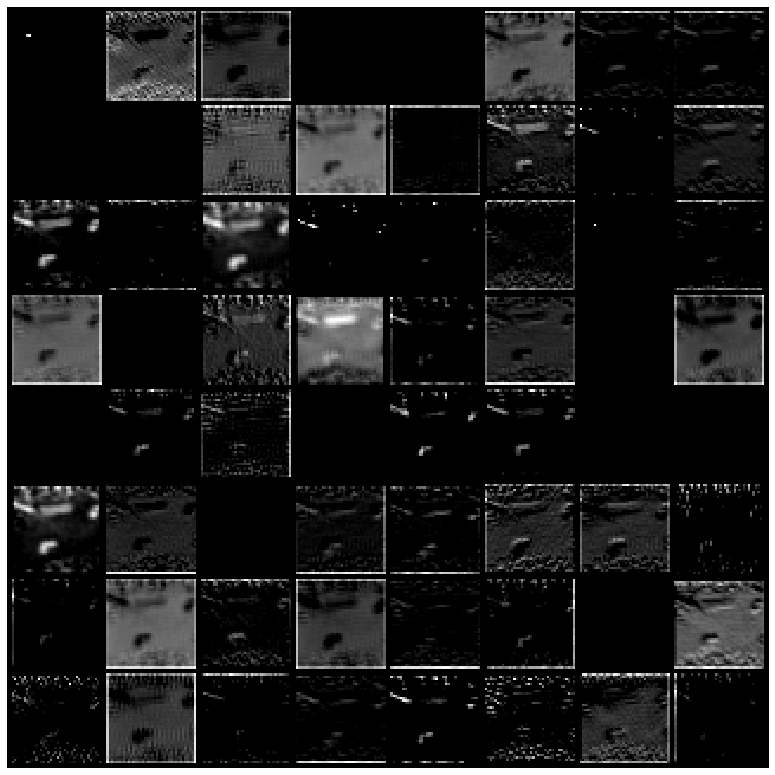

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([64, 1, 38, 38])


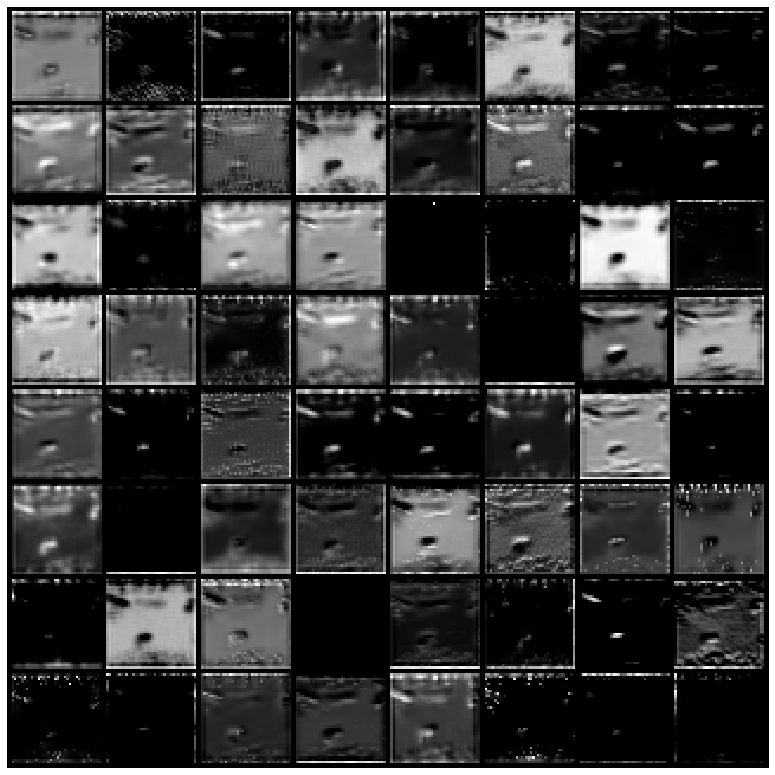

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, moment

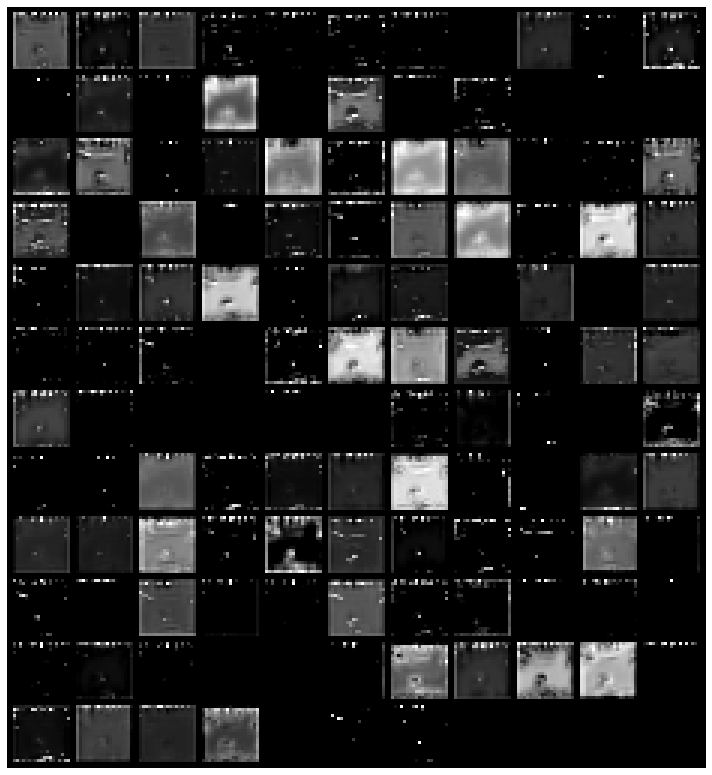

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, mome

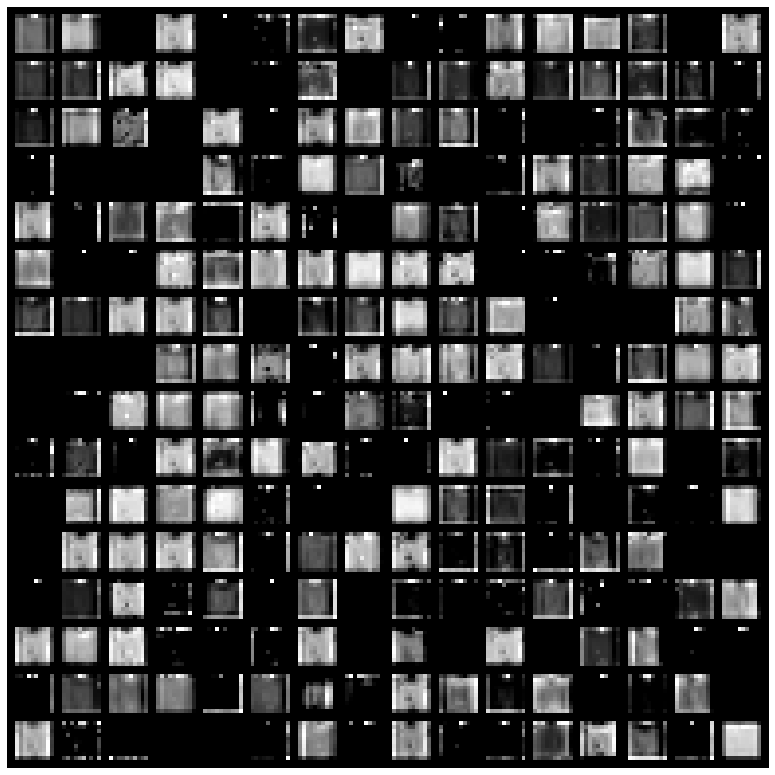

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, mome

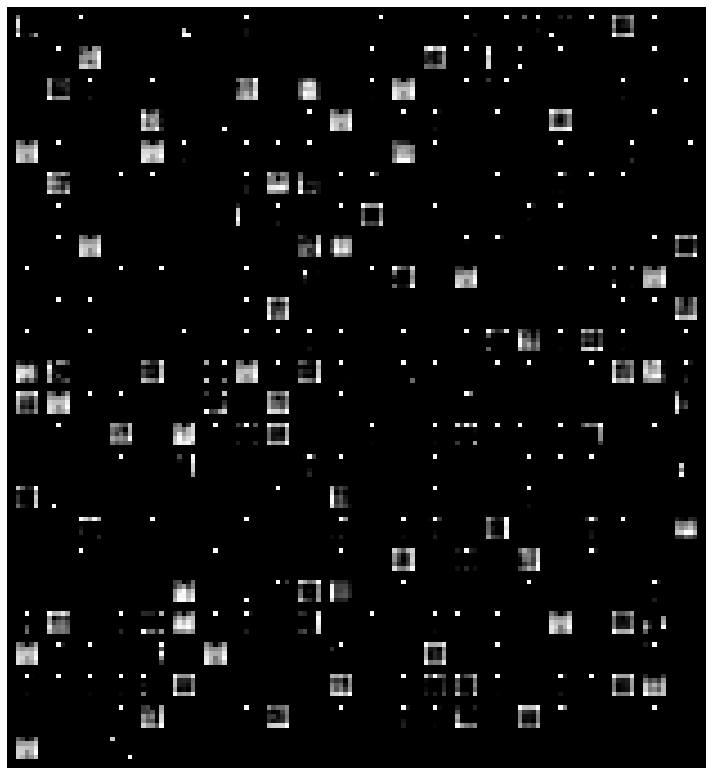

In [207]:
model_RGB.eval()

# idx = int(torch.rand(1) * len(val_ds))
im, label = val_ds[idx] 

plt.imshow(im.permute(1, 2, 0))
plt.title(f'{idx}, ' + ('building' if label == 1 else 'no building'))
plt.show()

with torch.no_grad():
    print(F.softmax(model_RGB(im.unsqueeze(0).cuda()), dim=-1))
    print()
    for i in range(1, 9):
        if i == 3:
            continue
        model_subset = nn.Sequential(*list(model_RGB.net._modules.values())[:i])
        model_subset.eval()
        fs = model_subset(im.unsqueeze(0).cuda()).detach().cpu().permute(1, 0, 2, 3)
        
        print(model_subset[i - 1])
        print(fs.shape)

        grid = utils.make_grid(fs, nrow=int(len(fs)**0.5), normalize=True, scale_each=True, padding=2).permute(1, 2, 0)
        # print(grid.shape)

        plt.figure(figsize=(14,14))
        plt.imshow(grid, cmap='gray')
        plt.axis('off')
        plt.show()

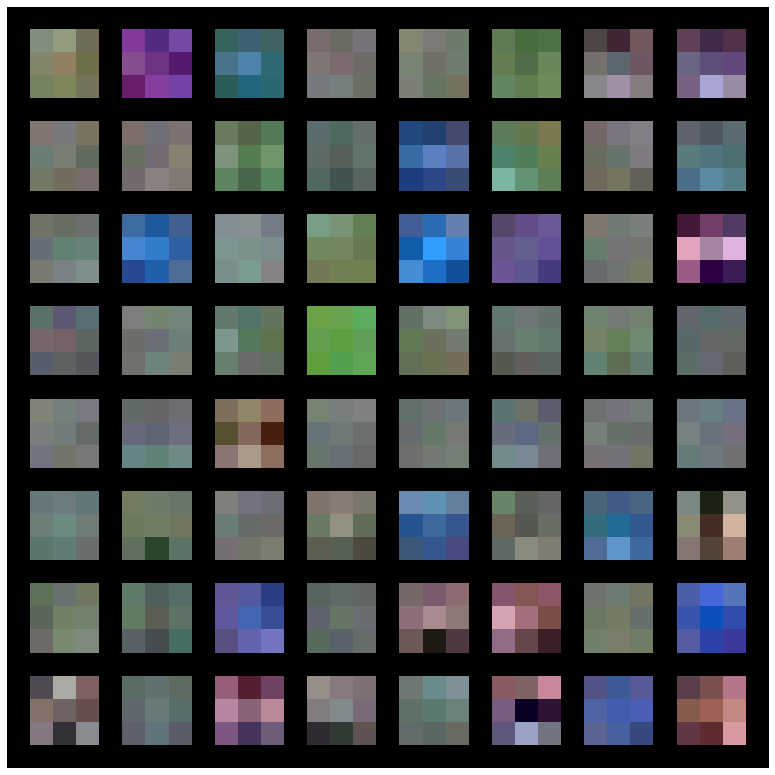

In [129]:
fs = model.net._modules['conv1'].weight.data.clone().detach().cpu()
grid = utils.make_grid(fs, normalize=True, padding=1).permute(1, 2, 0)

plt.figure(figsize=(14,14))
plt.imshow(grid, cmap='gray')
plt.axis('off')
plt.show()